In [1]:
import pandas as pd
import os, glob
import numpy as np
import re
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle, math

from sklearn.preprocessing import minmax_scale as mms



In [2]:
file = open('./df_cart.pth', 'rb')
df = pickle.load(file)
file.close()

In [3]:
df.head()

,Session,FileName,Start Frame,End Frame,Gaze Data,Pose Data,CR1,CR2,CR3,NR1,NR2,NR3,Encoded Future Roles
0,20170720,152000,7861,7921,"[[[-0.2762919566761853, -0.08595516415505236],...","[[[[-0.48589324 0.74852699], [-0.46514708 0....",AL,AL,MS,MS,SL,ML,"[1, 0, 0, 0, 0, 1, 0, 1, 0]"
1,20170720,152000,7861,7921,"[[[-0.29772805696593607, -1.2782949733579279],...","[[[[ 0.70480985 -0.65994347], [ 0.73870443 -0....",AL,MS,AL,SL,ML,MS,"[0, 0, 1, 0, 1, 0, 1, 0, 0]"
2,20170720,152000,7861,7921,"[[[-0.9960048570641209, -0.2788725407985221], ...","[[[[0.64574167 2.19534607], [0.62824857 2.1584...",MS,AL,AL,ML,MS,SL,"[0, 1, 0, 1, 0, 0, 0, 0, 1]"
3,20170720,152000,8599,8659,"[[[0.5333925858249581, -0.23489669449662276], ...","[[[[-0.50719443 0.78566188], [-0.49085116 0....",MS,AL,AL,ML,SL,MS,"[0, 1, 0, 0, 0, 1, 1, 0, 0]"
4,20170720,152000,8599,8659,"[[[-0.409351439913777, -0.9660370508176976], [...","[[[[ 0.6661028 -0.66592614], [ 0.69971534 -0....",AL,AL,MS,SL,MS,ML,"[0, 0, 1, 1, 0, 0, 0, 1, 0]"


In [17]:
def r2vec(r:str):
    if type(r)!=str:
        return np.array([0,0,0,1])
    if 'MS' in r:
        return np.array([ 1, 0, 0, 0])
    elif 'ML' in r:
        return np.array([0, 1, 0, 0])
    elif 'SL' in r:
        return np.array([0, 0, 1, 0])
    else:
        return np.array([0, 0, 0, 1])
        
def encodeRoles(r1:str, r2:str, r3:str):
    return np.hstack([r2vec(r1), r2vec(r2), r2vec(r3)])

    

In [18]:
roles = encodeRoles('MS', 'AL', 'MS')

In [13]:
roles[8:12]

array([1, 0, 0, 0])

In [19]:
df['Encoded Current Roles'] = df.apply(lambda x: encodeRoles(x['CR1'], x['CR2'], x['CR3']), axis=1)

In [21]:
file = open('df_cart.pth', 'wb')
pickle.dump(df, file)
file.close()

In [35]:
import librosa as lb
import IPython.display as ipd
import sklearn
import matplotlib.pyplot as plt
import librosa.display

In [113]:
base_path = r"\\siserver3.dil.atr.jp\database\MMDD3\20170720\separated\20170720-145149-672-c01.wav"
y,sr = librosa.load(path)

In [120]:
y.shape[0]/sr

299.9900680272109

In [118]:
path = './20170720-145500-000-c01.wav'

In [119]:
y,sr = librosa.load(path)

In [122]:
getAudioFrameFromVideoFrame(300*30, 30, sr)

6615000.0

In [127]:
getAudioFeatures(path, 100, 5000, 30).shape

(498,)

In [125]:
def getAudioFrameFromVideoFrame(frame:int, fps:int, sr:int):
    return int(sr*frame/fps)
    # Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return mms(x, axis=axis)

def get_mfcc(y, sr):
    return np.array(librosa.feature.mfcc(y=y, sr=sr))


def get_mel_spectrogram(y, sr):
    return np.array(librosa.feature.melspectrogram(y=y, sr=sr))


def get_chroma_vector(y, sr):
    return np.array(librosa.feature.chroma_stft(y=y, sr=sr))


def get_tonnetz(y, sr):
    return np.array(librosa.feature.tonnetz(y=y, sr=sr))

def loadDataFrame(path:str):
    df = []
    with open(path, 'rb') as file:
        df = pickle.load(file)
    return df

def get_feature(y, sr):
    mfcc = get_mfcc(y, sr)
    mfcc_mean = mfcc.mean(axis=1)
    mfcc_min = mfcc.min(axis=1)
    mfcc_max = mfcc.max(axis=1)
    mfcc_feature = np.concatenate((mfcc_mean, mfcc_min, mfcc_max))

    mel_spectrogram = get_mel_spectrogram(y, sr)
    mel_spectrogram_mean = mel_spectrogram.mean(axis=1)
    mel_spectrogram_min = mel_spectrogram.min(axis=1)
    mel_spectrogram_max = mel_spectrogram.max(axis=1)
    mel_spectrogram_feature = np.concatenate((mel_spectrogram_mean, mel_spectrogram_min, mel_spectrogram_max))

    chroma = get_chroma_vector(y, sr)
    chroma_mean = chroma.mean(axis=1)
    chroma_min = chroma.min(axis=1)
    chroma_max = chroma.max(axis=1)
    chroma_feature = np.concatenate((chroma_mean, chroma_min, chroma_max))

    tonnetz = get_tonnetz(y, sr)
    tonnetz_mean = tonnetz.mean(axis=1)
    tonnetz_min = tonnetz.min(axis=1)
    tonnetz_max = tonnetz.max(axis=1)
    tonnetz_feature = np.concatenate((tonnetz_mean, tonnetz_min, tonnetz_max))

    return np.concatenate((chroma_feature, mel_spectrogram_feature, mfcc_feature, tonnetz_feature))

def getAudioFeatures(path:str, start_frame:int, stop_frame:int, fps:int=30):
    y, sr = librosa.load(path)    
    audio_start = getAudioFrameFromVideoFrame(start_frame, fps, sr)
    audio_stop = getAudioFrameFromVideoFrame(stop_frame, fps, sr)
    y = y[audio_start:audio_stop]
    return get_feature(y,sr)

def audio2features(path:str, start_frame:int, stop_frame:int, fps:int=30):
    f1 = getAudioFeatures(path, start_frame, stop_frame, fps)
    f2 = getAudioFeatures(path.replace('c01', 'c02'), start_frame, stop_frame, fps)
    f3 = getAudioFeatures(path.replace('c01', 'c03'), start_frame, stop_frame, fps)
    return np.array([f1,f2,f3])

In [129]:
features = audio2features('./20170720-145500-000-c01.wav', 500, 1000, 30)

In [140]:
features[1] == features[2]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [141]:
df

,Session,FileName,Start Frame,End Frame,Gaze Data,Pose Data,CR1,CR2,CR3,NR1,NR2,NR3,Encoded Future Roles,Encoded Current Roles,audio_path
0,20170720,152000,7861,7921,"[[[-0.2762919566761853, -0.08595516415505236],...","[[[[-0.48589324 0.74852699], [-0.46514708 0....",AL,AL,MS,MS,SL,ML,"[1, 0, 0, 0, 0, 1, 0, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]",\\siserver3.dil.atr.jp\MMDDC3\20170720\separat...
1,20170720,152000,7861,7921,"[[[-0.29772805696593607, -1.2782949733579279],...","[[[[ 0.70480985 -0.65994347], [ 0.73870443 -0....",AL,MS,AL,SL,ML,MS,"[0, 0, 1, 0, 1, 0, 1, 0, 0]","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1]",\\siserver3.dil.atr.jp\MMDDC3\20170720\separat...
2,20170720,152000,7861,7921,"[[[-0.9960048570641209, -0.2788725407985221], ...","[[[[0.64574167 2.19534607], [0.62824857 2.1584...",MS,AL,AL,ML,MS,SL,"[0, 1, 0, 1, 0, 0, 0, 0, 1]","[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]",\\siserver3.dil.atr.jp\MMDDC3\20170720\separat...
3,20170720,152000,8599,8659,"[[[0.5333925858249581, -0.23489669449662276], ...","[[[[-0.50719443 0.78566188], [-0.49085116 0....",MS,AL,AL,ML,SL,MS,"[0, 1, 0, 0, 0, 1, 1, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]",\\siserver3.dil.atr.jp\MMDDC3\20170720\separat...
4,20170720,152000,8599,8659,"[[[-0.409351439913777, -0.9660370508176976], [...","[[[[ 0.6661028 -0.66592614], [ 0.69971534 -0....",AL,AL,MS,SL,MS,ML,"[0, 0, 1, 1, 0, 0, 0, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]",\\siserver3.dil.atr.jp\MMDDC3\20170720\separat...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16438,20220209,170500,4580,4640,"[[[-0.9626818841163548, -1.168941130056747], [...","[[[[ 0.64152494 -1.02302229], [ 0.67386338 -1....",ML,SL,MS,ML,SL,MS,"[0, 1, 0, 0, 0, 1, 1, 0, 0]","[0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]",\\siserver3.dil.atr.jp\MMDDC3\20220209\separat...
16439,20220209,170500,4580,4640,"[[[-0.9255368271702552, 0.10605172513568842], ...","[[[[0.43041423 2.42280137], [0.41421346 2.3915...",SL,MS,ML,SL,MS,ML,"[0, 0, 1, 1, 0, 0, 0, 1, 0]","[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0]",\\siserver3.dil.atr.jp\MMDDC3\20220209\separat...
16440,20220209,170500,4581,4641,"[[[0.11426225463586878, -0.38604811265509853],...","[[[[-0.75317659 0.6088784 ], [-0.73393732 0....",MS,ML,SL,ML,MS,SL,"[0, 1, 0, 1, 0, 0, 0, 0, 1]","[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]",\\siserver3.dil.atr.jp\MMDDC3\20220209\separat...
16441,20220209,170500,4581,4641,"[[[-0.9626818841163548, -1.168941130056747], [...","[[[[ 0.64152494 -1.02302229], [ 0.67386338 -1....",ML,SL,MS,MS,SL,ML,"[1, 0, 0, 0, 0, 1, 0, 1, 0]","[0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]",\\siserver3.dil.atr.jp\MMDDC3\20220209\separat...


In [88]:
df = loadDataFrame('./df_cart.pth')

In [96]:
df.head()

,Session,FileName,Start Frame,End Frame,Gaze Data,Pose Data,CR1,CR2,CR3,NR1,NR2,NR3,Encoded Future Roles,Encoded Current Roles
0,20170720,152000,7861,7921,"[[[-0.2762919566761853, -0.08595516415505236],...","[[[[-0.48589324 0.74852699], [-0.46514708 0....",AL,AL,MS,MS,SL,ML,"[1, 0, 0, 0, 0, 1, 0, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]"
1,20170720,152000,7861,7921,"[[[-0.29772805696593607, -1.2782949733579279],...","[[[[ 0.70480985 -0.65994347], [ 0.73870443 -0....",AL,MS,AL,SL,ML,MS,"[0, 0, 1, 0, 1, 0, 1, 0, 0]","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1]"
2,20170720,152000,7861,7921,"[[[-0.9960048570641209, -0.2788725407985221], ...","[[[[0.64574167 2.19534607], [0.62824857 2.1584...",MS,AL,AL,ML,MS,SL,"[0, 1, 0, 1, 0, 0, 0, 0, 1]","[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]"
3,20170720,152000,8599,8659,"[[[0.5333925858249581, -0.23489669449662276], ...","[[[[-0.50719443 0.78566188], [-0.49085116 0....",MS,AL,AL,ML,SL,MS,"[0, 1, 0, 0, 0, 1, 1, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]"
4,20170720,152000,8599,8659,"[[[-0.409351439913777, -0.9660370508176976], [...","[[[[ 0.6661028 -0.66592614], [ 0.69971534 -0....",AL,AL,MS,SL,MS,ML,"[0, 0, 1, 1, 0, 0, 0, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]"


In [134]:
def getPath(base_path:str,folder_name:str, file_name:str):
    file_name = folder_name +'-'+file_name+'-000-c01.wav'
    path = os.path.join(base_path, folder_name)
    path = os.path.join(path, "separated")
    path = os.path.join(path, file_name)
    return path
base_audio_path = r"\\siserver3.dil.atr.jp\database\MMDD3"
df['audio_path'] = df.apply(lambda x: getPath(base_audio_path, x['Session'], str(x['FileName'])), axis=1)

In [136]:
df

,Session,FileName,Start Frame,End Frame,Gaze Data,Pose Data,CR1,CR2,CR3,NR1,NR2,NR3,Encoded Future Roles,Encoded Current Roles,audio_path
0,20170720,152000,7861,7921,"[[[-0.2762919566761853, -0.08595516415505236],...","[[[[-0.48589324 0.74852699], [-0.46514708 0....",AL,AL,MS,MS,SL,ML,"[1, 0, 0, 0, 0, 1, 0, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]",\\siserver3.dil.atr.jp\MMDDC3\20170720\separat...
1,20170720,152000,7861,7921,"[[[-0.29772805696593607, -1.2782949733579279],...","[[[[ 0.70480985 -0.65994347], [ 0.73870443 -0....",AL,MS,AL,SL,ML,MS,"[0, 0, 1, 0, 1, 0, 1, 0, 0]","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1]",\\siserver3.dil.atr.jp\MMDDC3\20170720\separat...
2,20170720,152000,7861,7921,"[[[-0.9960048570641209, -0.2788725407985221], ...","[[[[0.64574167 2.19534607], [0.62824857 2.1584...",MS,AL,AL,ML,MS,SL,"[0, 1, 0, 1, 0, 0, 0, 0, 1]","[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]",\\siserver3.dil.atr.jp\MMDDC3\20170720\separat...
3,20170720,152000,8599,8659,"[[[0.5333925858249581, -0.23489669449662276], ...","[[[[-0.50719443 0.78566188], [-0.49085116 0....",MS,AL,AL,ML,SL,MS,"[0, 1, 0, 0, 0, 1, 1, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]",\\siserver3.dil.atr.jp\MMDDC3\20170720\separat...
4,20170720,152000,8599,8659,"[[[-0.409351439913777, -0.9660370508176976], [...","[[[[ 0.6661028 -0.66592614], [ 0.69971534 -0....",AL,AL,MS,SL,MS,ML,"[0, 0, 1, 1, 0, 0, 0, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]",\\siserver3.dil.atr.jp\MMDDC3\20170720\separat...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16438,20220209,170500,4580,4640,"[[[-0.9626818841163548, -1.168941130056747], [...","[[[[ 0.64152494 -1.02302229], [ 0.67386338 -1....",ML,SL,MS,ML,SL,MS,"[0, 1, 0, 0, 0, 1, 1, 0, 0]","[0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]",\\siserver3.dil.atr.jp\MMDDC3\20220209\separat...
16439,20220209,170500,4580,4640,"[[[-0.9255368271702552, 0.10605172513568842], ...","[[[[0.43041423 2.42280137], [0.41421346 2.3915...",SL,MS,ML,SL,MS,ML,"[0, 0, 1, 1, 0, 0, 0, 1, 0]","[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0]",\\siserver3.dil.atr.jp\MMDDC3\20220209\separat...
16440,20220209,170500,4581,4641,"[[[0.11426225463586878, -0.38604811265509853],...","[[[[-0.75317659 0.6088784 ], [-0.73393732 0....",MS,ML,SL,ML,MS,SL,"[0, 1, 0, 1, 0, 0, 0, 0, 1]","[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]",\\siserver3.dil.atr.jp\MMDDC3\20220209\separat...
16441,20220209,170500,4581,4641,"[[[-0.9626818841163548, -1.168941130056747], [...","[[[[ 0.64152494 -1.02302229], [ 0.67386338 -1....",ML,SL,MS,MS,SL,ML,"[1, 0, 0, 0, 0, 1, 0, 1, 0]","[0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]",\\siserver3.dil.atr.jp\MMDDC3\20220209\separat...


In [110]:

df['Encoded Audio Features'] = df.apply(lambda x: audio2features(x['audio_path'], x['Start Frame'], x['Stop Frame']))

,Session,FileName,Start Frame,End Frame,Gaze Data,Pose Data,CR1,CR2,CR3,NR1,NR2,NR3,Encoded Future Roles,Encoded Current Roles,audio_path
0,20170720,152000,7861,7921,"[[[-0.2762919566761853, -0.08595516415505236],...","[[[[-0.48589324 0.74852699], [-0.46514708 0....",AL,AL,MS,MS,SL,ML,"[1, 0, 0, 0, 0, 1, 0, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]",\\siserver3.dil.atr.jp\MMDDC3\20170720\middle_...
1,20170720,152000,7861,7921,"[[[-0.29772805696593607, -1.2782949733579279],...","[[[[ 0.70480985 -0.65994347], [ 0.73870443 -0....",AL,MS,AL,SL,ML,MS,"[0, 0, 1, 0, 1, 0, 1, 0, 0]","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1]",\\siserver3.dil.atr.jp\MMDDC3\20170720\middle_...
2,20170720,152000,7861,7921,"[[[-0.9960048570641209, -0.2788725407985221], ...","[[[[0.64574167 2.19534607], [0.62824857 2.1584...",MS,AL,AL,ML,MS,SL,"[0, 1, 0, 1, 0, 0, 0, 0, 1]","[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]",\\siserver3.dil.atr.jp\MMDDC3\20170720\middle_...
3,20170720,152000,8599,8659,"[[[0.5333925858249581, -0.23489669449662276], ...","[[[[-0.50719443 0.78566188], [-0.49085116 0....",MS,AL,AL,ML,SL,MS,"[0, 1, 0, 0, 0, 1, 1, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]",\\siserver3.dil.atr.jp\MMDDC3\20170720\middle_...
4,20170720,152000,8599,8659,"[[[-0.409351439913777, -0.9660370508176976], [...","[[[[ 0.6661028 -0.66592614], [ 0.69971534 -0....",AL,AL,MS,SL,MS,ML,"[0, 0, 1, 1, 0, 0, 0, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]",\\siserver3.dil.atr.jp\MMDDC3\20170720\middle_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16438,20220209,170500,4580,4640,"[[[-0.9626818841163548, -1.168941130056747], [...","[[[[ 0.64152494 -1.02302229], [ 0.67386338 -1....",ML,SL,MS,ML,SL,MS,"[0, 1, 0, 0, 0, 1, 1, 0, 0]","[0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]",\\siserver3.dil.atr.jp\MMDDC3\20220209\middle_...
16439,20220209,170500,4580,4640,"[[[-0.9255368271702552, 0.10605172513568842], ...","[[[[0.43041423 2.42280137], [0.41421346 2.3915...",SL,MS,ML,SL,MS,ML,"[0, 0, 1, 1, 0, 0, 0, 1, 0]","[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0]",\\siserver3.dil.atr.jp\MMDDC3\20220209\middle_...
16440,20220209,170500,4581,4641,"[[[0.11426225463586878, -0.38604811265509853],...","[[[[-0.75317659 0.6088784 ], [-0.73393732 0....",MS,ML,SL,ML,MS,SL,"[0, 1, 0, 1, 0, 0, 0, 0, 1]","[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]",\\siserver3.dil.atr.jp\MMDDC3\20220209\middle_...
16441,20220209,170500,4581,4641,"[[[-0.9626818841163548, -1.168941130056747], [...","[[[[ 0.64152494 -1.02302229], [ 0.67386338 -1....",ML,SL,MS,MS,SL,ML,"[1, 0, 0, 0, 0, 1, 0, 1, 0]","[0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]",\\siserver3.dil.atr.jp\MMDDC3\20220209\middle_...


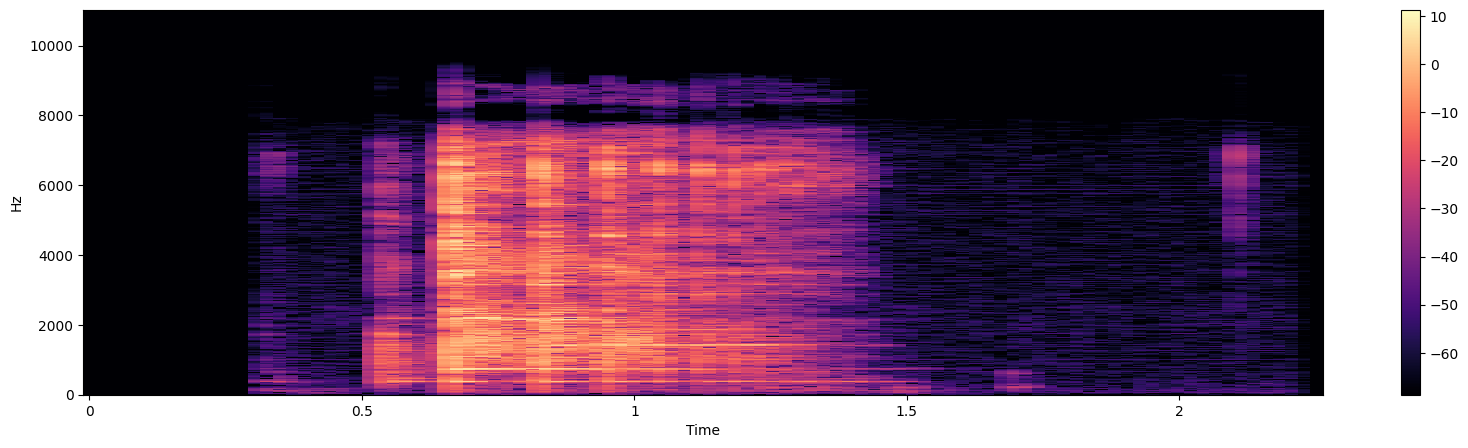

In [38]:
#compute the spectogram
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(20, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

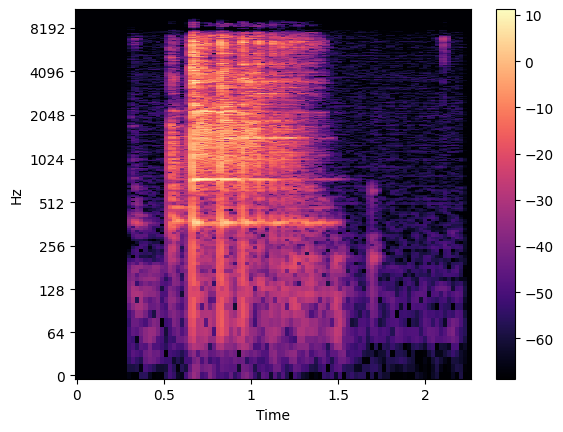

In [39]:
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

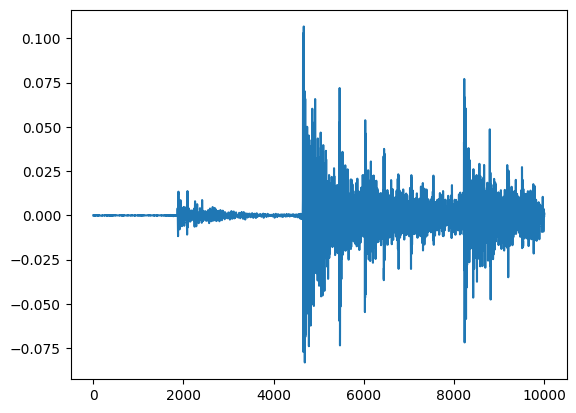

In [43]:
plt.plot(x[10000:20000])

In [48]:
#Zero Crossings
zero_crossings = librosa.zero_crossings(x[10000:20000], pad=False)
zero_crossings = zero_crossings.sum()
zero_crossings

2077

In [63]:
#get spectral centroids

from sklearn.preprocessing import minmax_scale as mms


spectral_centroids = librosa.feature.spectral_centroid(y  = x[10000:20000], sr=sr)[0]
plt.figure(figsize=(20,5))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return mms(x, axis=axis)

#Plotting the Spectral Centroid along the waveform
librosa.display.waveshow(x[10000:20000], sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')


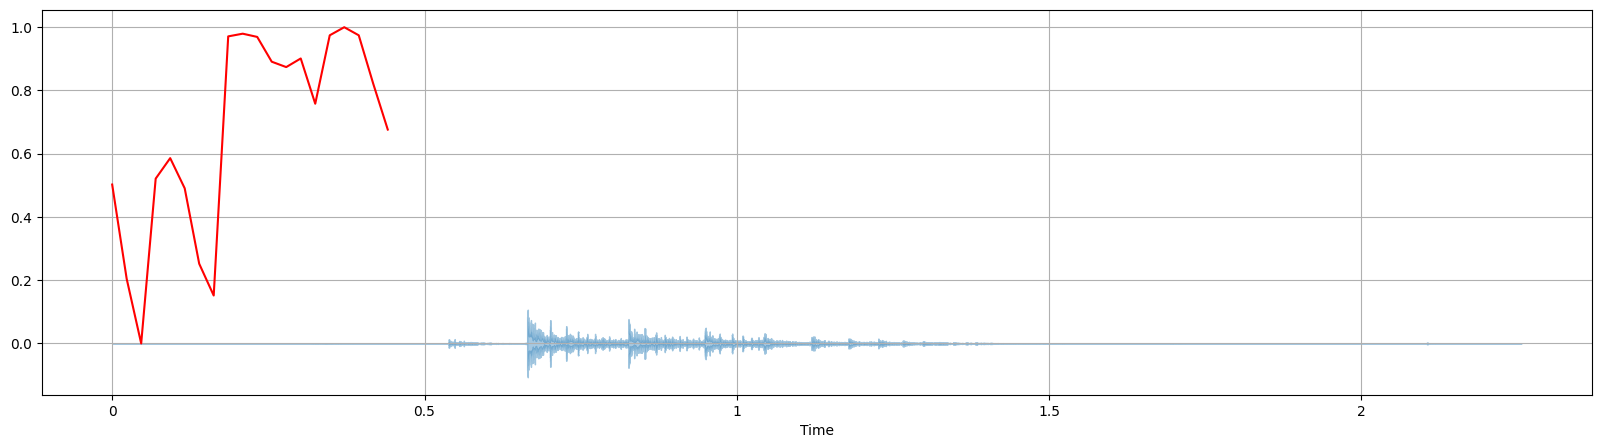

In [74]:
#spectal rolloff
plt.figure(figsize=(20,5))
spectral_rolloff = librosa.feature.spectral_rolloff(y =x[10000:20000]+0.01, sr=sr)[0]
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')
plt.grid()


(20, 98)


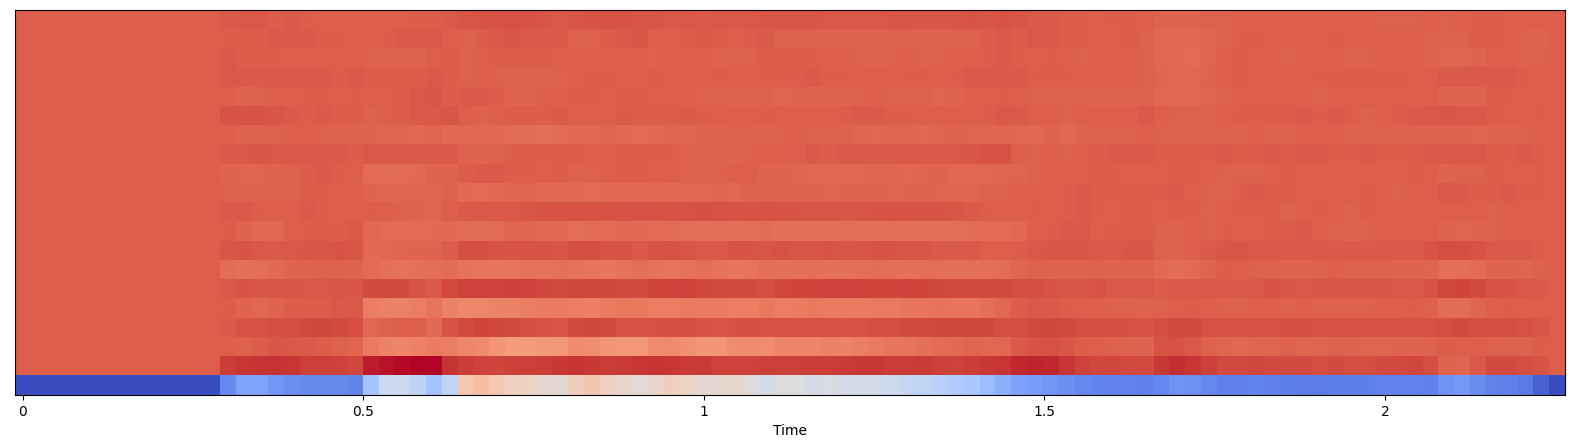

In [77]:
plt.figure(figsize=(20,5))
mfccs = librosa.feature.mfcc(y=x, sr=sr)
print(mfccs.shape)

librosa.display.specshow(mfccs, sr=sr, x_axis='time')

In [78]:
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print(mfccs.mean(axis=1))



[-2.0679163e-08 -1.0947792e-08  6.0821065e-10  2.4328426e-09
  2.5544848e-08  1.4597056e-08 -1.2164213e-09 -2.4328426e-09
 -1.2164214e-08 -1.0947792e-08 -1.4597056e-08  8.5149496e-09
  1.3380634e-08  0.0000000e+00  0.0000000e+00 -7.6026332e-09
  3.9533692e-09 -6.0821065e-10  6.4622383e-09 -1.0339582e-08]
[0.99999994 0.9999998  1.0000001  0.99999994 1.         1.
 1.         1.         1.0000001  0.99999994 0.9999998  1.0000001
 1.0000001  1.         0.99999994 1.         0.9999998  0.99999994
 1.         1.        ]


c:\Users\irdal\.conda\envs\eyegaze\lib\site-packages\sklearn\preprocessing\_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\irdal\.conda\envs\eyegaze\lib\site-packages\sklearn\preprocessing\_data.py:259: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


In [79]:
def getAudioFrameFromVideoFrame(frame:int, fps:int, sr:int):
    return sr*frame/fps
    # Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return mms(x, axis=axis)
    
def getAudioFeatures(path:str, start_frame:int, stop_frame:int, fps:int = 30):
    
    #load the file into array and get the sub array from the file
    y, sr = librosa.load(path)
    audio_start = getAudioFrameFromVideoFrame(start_frame, fps, sr)
    audio_stop = getAudioFrameFromVideoFrame(stop_frame, fps, sr)
    y = y[audio_start:audio_stop]
    
    #get zero crossings
    zero_crossings = librosa.zero_crossings(y, pad=False)
    zero_crossings = zero_crossings.sum()
    
    #get spherical centroid
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    spectral_centroids = normalize(spectral_centroids)
    
    #spectral_roll_off

In [80]:
def get_mfcc(y, sr):
    return np.array(librosa.feature.mfcc(y=y, sr=sr))


def get_mel_spectrogram(y, sr):
    return np.array(librosa.feature.melspectrogram(y=y, sr=sr))


def get_chroma_vector(y, sr):
    return np.array(librosa.feature.chroma_stft(y=y, sr=sr))


def get_tonnetz(y, sr):
    return np.array(librosa.feature.tonnetz(y=y, sr=sr))


def get_feature(y, sr):
    mfcc = get_mfcc(y, sr)
    mfcc_mean = mfcc.mean(axis=1)
    mfcc_min = mfcc.min(axis=1)
    mfcc_max = mfcc.max(axis=1)
    mfcc_feature = np.concatenate((mfcc_mean, mfcc_min, mfcc_max))

    mel_spectrogram = get_mel_spectrogram(y, sr)
    mel_spectrogram_mean = mel_spectrogram.mean(axis=1)
    mel_spectrogram_min = mel_spectrogram.min(axis=1)
    mel_spectrogram_max = mel_spectrogram.max(axis=1)
    mel_spectrogram_feature = np.concatenate((mel_spectrogram_mean, mel_spectrogram_min, mel_spectrogram_max))

    chroma = get_chroma_vector(y, sr)
    chroma_mean = chroma.mean(axis=1)
    chroma_min = chroma.min(axis=1)
    chroma_max = chroma.max(axis=1)
    chroma_feature = np.concatenate((chroma_mean, chroma_min, chroma_max))

    tonnetz = get_tonnetz(y, sr)
    tonnetz_mean = tonnetz.mean(axis=1)
    tonnetz_min = tonnetz.min(axis=1)
    tonnetz_max = tonnetz.max(axis=1)
    tonnetz_feature = np.concatenate((tonnetz_mean, tonnetz_min, tonnetz_max))

    return np.concatenate((chroma_feature, mel_spectrogram_feature, mfcc_feature, tonnetz_feature))

,Session,FileName,Start Frame,End Frame,Gaze Data,Pose Data,CR1,CR2,CR3,NR1,NR2,NR3,Encoded Future Roles,Encoded Current Roles
0,20170720,152000,7861,7921,"[[[-0.2762919566761853, -0.08595516415505236],...","[[[[-0.48589324 0.74852699], [-0.46514708 0....",AL,AL,MS,MS,SL,ML,"[1, 0, 0, 0, 0, 1, 0, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]"
1,20170720,152000,7861,7921,"[[[-0.29772805696593607, -1.2782949733579279],...","[[[[ 0.70480985 -0.65994347], [ 0.73870443 -0....",AL,MS,AL,SL,ML,MS,"[0, 0, 1, 0, 1, 0, 1, 0, 0]","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1]"
2,20170720,152000,7861,7921,"[[[-0.9960048570641209, -0.2788725407985221], ...","[[[[0.64574167 2.19534607], [0.62824857 2.1584...",MS,AL,AL,ML,MS,SL,"[0, 1, 0, 1, 0, 0, 0, 0, 1]","[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]"
3,20170720,152000,8599,8659,"[[[0.5333925858249581, -0.23489669449662276], ...","[[[[-0.50719443 0.78566188], [-0.49085116 0....",MS,AL,AL,ML,SL,MS,"[0, 1, 0, 0, 0, 1, 1, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]"
4,20170720,152000,8599,8659,"[[[-0.409351439913777, -0.9660370508176976], [...","[[[[ 0.6661028 -0.66592614], [ 0.69971534 -0....",AL,AL,MS,SL,MS,ML,"[0, 0, 1, 1, 0, 0, 0, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16438,20220209,170500,4580,4640,"[[[-0.9626818841163548, -1.168941130056747], [...","[[[[ 0.64152494 -1.02302229], [ 0.67386338 -1....",ML,SL,MS,ML,SL,MS,"[0, 1, 0, 0, 0, 1, 1, 0, 0]","[0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]"
16439,20220209,170500,4580,4640,"[[[-0.9255368271702552, 0.10605172513568842], ...","[[[[0.43041423 2.42280137], [0.41421346 2.3915...",SL,MS,ML,SL,MS,ML,"[0, 0, 1, 1, 0, 0, 0, 1, 0]","[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0]"
16440,20220209,170500,4581,4641,"[[[0.11426225463586878, -0.38604811265509853],...","[[[[-0.75317659 0.6088784 ], [-0.73393732 0....",MS,ML,SL,ML,MS,SL,"[0, 1, 0, 1, 0, 0, 0, 0, 1]","[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]"
16441,20220209,170500,4581,4641,"[[[-0.9626818841163548, -1.168941130056747], [...","[[[[ 0.64152494 -1.02302229], [ 0.67386338 -1....",ML,SL,MS,MS,SL,ML,"[1, 0, 0, 0, 0, 1, 0, 1, 0]","[0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]"
